# Symbolic computations for the 1D disturbed study

In [1]:
import sympy as sp
sp.init_printing()

import IPython.display as disp

# 1D
# Continuous piecewise linear functions
drawing = f"""
    .____.________.
    x-1  x0      x1
    |____|________|
      hx-    hx+

"""
print(drawing)


    .____.________.
    x-1  x0      x1
    |____|________|
      hx-    hx+




In [2]:
# !!! Indicates a hypothesis (should be studied and considered)

# !!! Mode selection
mode_values = "real" # real or complex values


In [3]:
# Wavenumbers
k = sp.Symbol('k',
              #real=True, # !!!
              #positive=True, # !!!
              )
kh = sp.symbols('k^h')

# 1D variable
x = sp.symbols('x')

# 1D variational formulations over [a, b]
tau = sp.symbols('tau')
def a_G(u, v, a, b):
    D_u = sp.diff(u, x)
    D_v = sp.diff(v, x)
    return sp.integrate(D_u*D_v, (x, a, b)) - ( k**2 * sp.integrate(u*v, (x, a, b)) )


Galerkine coefficients


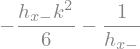

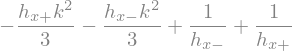

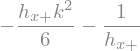

In [4]:

# h definitions
h_x_ = dict()
h_x_["-"], h_x_["+"] = sp.symbols('h_x- h_x+')
h_x = sp.symbols('h_x')

# Grid sample
x_ = dict()
x_["-1"], x_["0"], x_["+1"] = -h_x_["-"], sp.sympify(0), +h_x_["+"]

# Shape functions
N_ = dict()
N_["-1"] = - x / h_x_["-"]
N_["0-"] = (x / h_x_["-"]) + 1
N_["0+"] = (- x / h_x_["+"]) + 1
N_["+1"] = x / h_x_["+"]

# Linear system coefficients (Galerkine)
A_G_ = dict()
A_G_["0, -1"] = a_G(N_["0-"], N_["-1"], x_["-1"], x_["0"])
A_G_["0, 0"] = a_G(N_["0-"], N_["0-"], x_["-1"], x_["0"]) + a_G(N_["0+"], N_["0+"], x_["0"], x_["+1"])
A_G_["0, +1"] = a_G(N_["0+"], N_["+1"], x_["0"], x_["+1"])
# Checkpoint: another result should be equal to lambda * A_G_ with lambda any scalar (coefficients of a homogeneous system)
print("Galerkine coefficients")
for a in A_G_.values():
    disp.display(a)


In [5]:
# Numerical solution is supposedly
if mode_values == "complex":
    uh = sp.exp(1j * kh * x)
elif mode_values == "real":
    uh = sp.cos(kh * x)
Uh_ = dict()
Uh_["-1"] = uh.subs(x, x_["-1"])
Uh_["0"] = uh.subs(x, x_["0"])
Uh_["+1"] = uh.subs(x, x_["+1"])

Dispersion relation


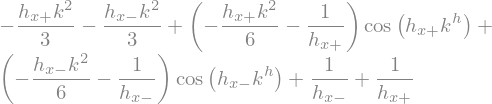

In [6]:

# Solve the A_G * Uh = 0 Galerkine stencil
dispersion_relation_G = (A_G_["0, -1"] * Uh_["-1"]) + (A_G_["0, 0"] * Uh_["0"]) + (A_G_["0, +1"] * Uh_["+1"])
print("Dispersion relation")
disp.display(dispersion_relation_G)

Galerkine dispersion
k^2 = 


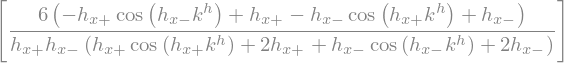

In [7]:
# for k (kh is non analytic in k when hx+ != hx-)
k2_G = sp.solve( dispersion_relation_G, k**2 )
print("Galerkine dispersion")
print("k^2 = ")
disp.display(k2_G)
k2_G = k2_G[0]


In [8]:
# Asymptotic results
alpha_ = dict()
alpha_["-"], alpha_["+"] = sp.symbols('alpha^- alpha^+', real=True, positive=True)


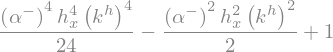

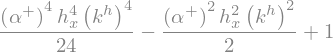

In [9]:
cos_asymptotic_ = dict()
cos_asymptotic_["-"] = sp.sympify(1) - (alpha_["-"]**2/2) * (h_x*kh)**2 + (alpha_["-"]**4/24) * (h_x*kh)**4
cos_asymptotic_["+"] = sp.sympify(1) - (alpha_["+"]**2/2) * (h_x*kh)**2 + (alpha_["+"]**4/24) * (h_x*kh)**4
disp.display(cos_asymptotic_["-"])
disp.display(cos_asymptotic_["+"])


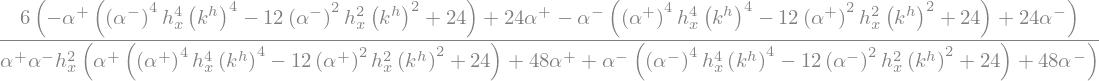

In [10]:
k2_G_asymptotic = k2_G.subs([(sp.cos(h_x_["-"]*kh), cos_asymptotic_["-"]),
                             (sp.cos(h_x_["+"]*kh), cos_asymptotic_["+"])]).subs([
                                 (h_x_["-"], alpha_["-"]*h_x),
                                 (h_x_["+"], alpha_["+"]*h_x)
                             ]).simplify()
disp.display(k2_G_asymptotic)

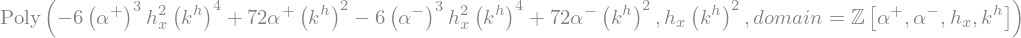

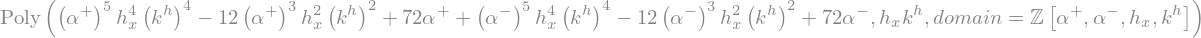

In [11]:
k2_G_asymptotic_numer, k2_G_asymptotic_denom = k2_G_asymptotic.as_numer_denom()
k2_G_asymptotic_numer = sp.Poly((k2_G_asymptotic_numer/(alpha_["-"]*alpha_["+"]*h_x*h_x)).expand(), h_x*(kh**2))
k2_G_asymptotic_denom = sp.Poly((k2_G_asymptotic_denom/(alpha_["-"]*alpha_["+"]*h_x*h_x)).expand(), h_x*kh)
disp.display(k2_G_asymptotic_numer)
disp.display(k2_G_asymptotic_denom)

Galerkine dispersion with hx+ = hx-
k^2 = 


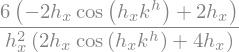

Galerkine dispersion with hx+ = hx-
kh*h = 


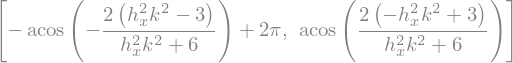

In [12]:
k2hh_G_asymptotic = k2_G_asymptotic*h_x_["-"]*h_x_["+"]
# Check for consistency with hx+ = hx-
k2_G_equal = k2_G.subs(h_x_["+"], h_x).subs(h_x_["-"], h_x)
print("Galerkine dispersion with hx+ = hx-")
print("k^2 = ")
disp.display(k2_G_equal)

# Now k^h is analytic
khh_G_equal = sp.solve(k**2 - k2_G_equal, kh*h_x)
print("Galerkine dispersion with hx+ = hx-")
print("kh*h = ")
disp.display(khh_G_equal)

Now let's plot and compare the relations between $k$ and $k^h$:
- The first approach uses the exact $k^2$ expression to compute a map from $k^h$ to $k$
- The second approach uses the asymptotic $k^h$ expression

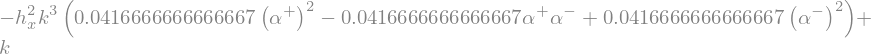

In [13]:
import numpy as np


# Exact kh -> k
exact_k_func = sp.lambdify(args=[h_x_["-"], h_x_["+"], kh], expr=sp.sqrt(k2_G))

# Asymptotic k -> kh
kh_G_asymptotic = k - (sp.sympify(1/24) * (alpha_["-"]**2 + alpha_["+"]**2 - alpha_["-"]*alpha_["+"]) * (k**3 * h_x**2))
disp.display(kh_G_asymptotic)
asymptotic_kh_func = sp.lambdify(args=[alpha_["-"], alpha_["+"], h_x, k], expr=kh_G_asymptotic)


In [14]:
%matplotlib ipympl
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True

def plot(HX, ALPHA_M, ALPHA_P):
    
    HX_M = ALPHA_M * HX
    HX_P = ALPHA_P * HX
    
    KH = np.linspace(0, 2, num=200)[1:]
    exact_K = exact_k_func(HX_M, HX_P, KH)

    K = np.linspace(0, 2, num=200)[1:]
    asymptotic_KH = asymptotic_kh_func(ALPHA_M, ALPHA_P, HX, K)
    
    fig, ax = plt.subplots()
    ax.set_title(f"Dispersion with {HX}, {ALPHA_M}, {ALPHA_P}")
    ax.set_xlabel("k")
    ax.set_ylabel('k^h')
    ax.plot(exact_K, KH, label="exact")
    ax.plot(K, asymptotic_KH, label = "asymptotic")
    ax.plot(K, K, label = "identity")
    ax.legend()


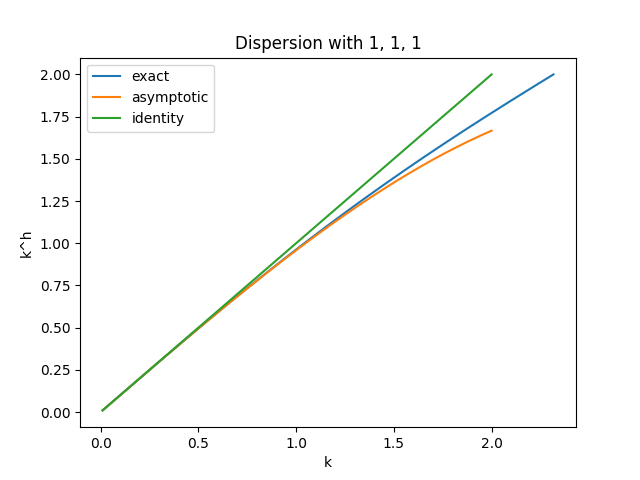

In [15]:
plot(HX=1, ALPHA_M=1, ALPHA_P=1)

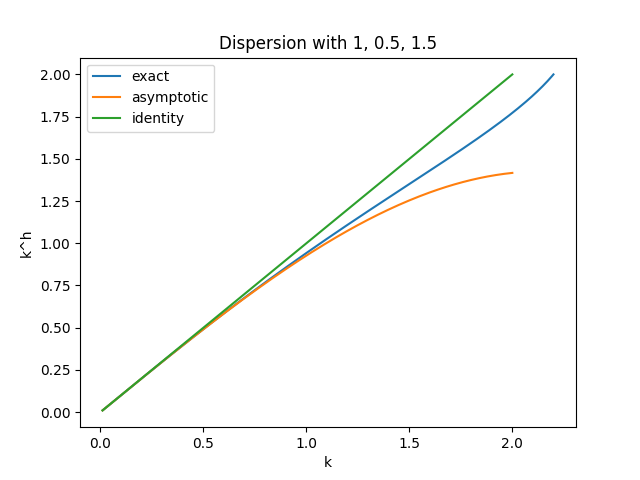

In [18]:
plot(HX=1, ALPHA_M=0.5, ALPHA_P=1.5)

The results for $kh < 1$ are really accurate